### Setup Environment:

In [1]:
from src.get_dataset import split_data
from src.data_loader import BRSETDataset, process_labels
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# loss function and optimizer
from src.FocalLoss import BinaryFocalLoss, FocalLoss

# train and test functions
from src.train import train
from src.test import test

In [2]:
# Constants:
DATASET = '/home/opc/Retina/BRSET/'
DOWNLOAD = False
SHAPE = (224, 224)
IMAGES = os.path.join(DATASET, 'images/')
LABEL = 'diabetes'
TEST_SIZE = 0.7
UNDERSAMPLE = False

LABELS_PATH = os.path.join(DATASET, 'labels.csv')
IMAGE_COL = 'image_id'

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
"""

NORM_MEAN = None # [0.485, 0.456, 0.406]
NORM_STD = None # [0.229, 0.224, 0.225]

BACKBONE = 'convnextv2_base'
MODE = 'fine_tune'
backbone_mode = 'eval'

HIDDEN = [128]
num_classes = 2

BATCH_SIZE = 16
NUM_WORKERS = 8

LOSS = None #'focal_loss'
OPTIMIZER = 'adam'

# Define your hyperparameters
num_epochs = 50
learning_rate = 1e-5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read csv file:

In [3]:
df_train = pd.read_csv(os.path.join(DATASET, 'train_ssl.csv'))
df_test = pd.read_csv(os.path.join(DATASET, 'test_ssl.csv'))

In [4]:
# Map values to categories
#df_train[LABEL] = df_train[LABEL].apply(lambda x: 'True' if x == 'yes' else 'False')
#df_test[LABEL] = df_train[LABEL].apply(lambda x: 'True' if x == 'yes' else 'False')

Getting validation set...
Train data shape: (5205, 35)
Test data shape: (1302, 35)


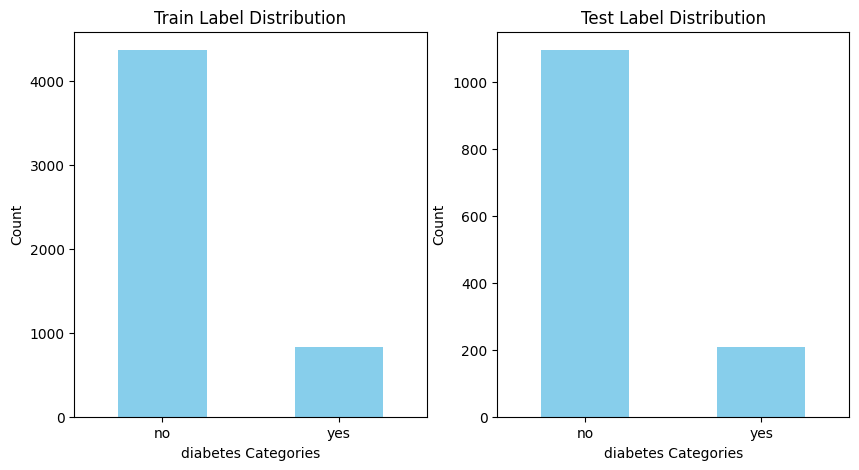

In [5]:
# Split dataset into train, test and validation:
#df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=False)
print('Getting validation set...')
df_test, df_val = split_data(df_test, LABEL, 0.20)

### Dataloaders

In [6]:
# Train the one hot encoder on the train set and get the labels for the test and validation sets:
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)

In [7]:
# Define the target image shape
SHAPE = (224, 224)  # Adjust to your desired image size

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(50),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))


In [8]:
# Create the custom dataset
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

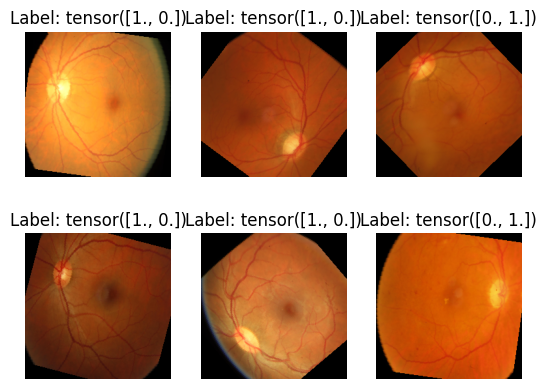

In [9]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels
for batch in train_dataloader:
    images, labels = batch['image'], batch['labels']

    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
    break

### Model

In [13]:
# Create the model
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE)
# Load backbone weights:
backbone_model.load_state_dict(torch.load('Models/checkpoint_convnextv2_base_byol.pt'))
model = FoundationalCVModelWithClassifier(backbone_model, hidden=HIDDEN, num_classes=num_classes, mode=MODE, backbone_mode=backbone_mode)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

Using 2 GPUs!


### Training:

In [11]:
if LOSS == 'focal_loss':
    class_distribution = train_dataloader.dataset.labels.sum(axis=0)
    print(f'Class distribution: {class_distribution}')
    class_dis = np.array(class_distribution)
    class_weights =1-class_dis/np.sum(class_dis)
    weights = torch.tensor(class_weights).to(device)
    #criterion = FocalLoss()  # Focal Loss
    criterion = FocalLoss(gamma=2, alpha=weights)
else:
    # Assuming train_loader.dataset.labels is a one-hot representation
    class_indices = np.argmax(train_dataloader.dataset.labels, axis=1)

    # Compute class weights using class indices
    class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    #criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [12]:
model = train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs, save=True, device=device, backbone=f'convnextv2_binary_{LABEL}_byol')

100%|██████████| 82/82 [00:13<00:00,  6.28it/s]


Epoch 1, Train Loss: 0.6293695333062626, Val Loss: 0.5761754970724989, F1 Score: 0.5183476671897035


100%|██████████| 82/82 [00:13<00:00,  6.21it/s]


Epoch 2, Train Loss: 0.5688218373988495, Val Loss: 0.49501512290501015, F1 Score: 0.6397184582912621


100%|██████████| 82/82 [00:13<00:00,  6.23it/s]


Epoch 3, Train Loss: 0.543893252484134, Val Loss: 0.5117407871819124, F1 Score: 0.5529482979632531


100%|██████████| 82/82 [00:13<00:00,  6.15it/s]


Epoch 4, Train Loss: 0.5336611411122025, Val Loss: 0.4602256237370212, F1 Score: 0.6692073170731707


100%|██████████| 82/82 [00:13<00:00,  6.19it/s]


Epoch 5, Train Loss: 0.5118309870118001, Val Loss: 0.45985424246002987, F1 Score: 0.6602296450939458


100%|██████████| 82/82 [00:13<00:00,  6.04it/s]


Epoch 6, Train Loss: 0.4988021155605551, Val Loss: 0.47609449959382777, F1 Score: 0.6258628461511297


100%|██████████| 82/82 [00:13<00:00,  6.12it/s]


Epoch 7, Train Loss: 0.4840448356309875, Val Loss: 0.45053571989623514, F1 Score: 0.6852858474096923


100%|██████████| 82/82 [00:13<00:00,  6.26it/s]


Epoch 8, Train Loss: 0.4795733899488801, Val Loss: 0.5051869015868117, F1 Score: 0.6058565802739089


100%|██████████| 82/82 [00:13<00:00,  6.12it/s]


Epoch 9, Train Loss: 0.46552679350630183, Val Loss: 0.460195804877979, F1 Score: 0.6758719904454277


100%|██████████| 82/82 [00:13<00:00,  6.28it/s]


Epoch 10, Train Loss: 0.4472567651848324, Val Loss: 0.5028062622721602, F1 Score: 0.7024311258483373


100%|██████████| 82/82 [00:13<00:00,  6.23it/s]


Epoch 11, Train Loss: 0.42514962087400626, Val Loss: 0.4542874721128766, F1 Score: 0.6810490556487487


100%|██████████| 82/82 [00:13<00:00,  6.19it/s]


Epoch 12, Train Loss: 0.4318833446038551, Val Loss: 0.4757233901721675, F1 Score: 0.6428788888378292


100%|██████████| 82/82 [00:13<00:00,  6.17it/s]


Epoch 13, Train Loss: 0.4013645288397054, Val Loss: 0.4438394673350381, F1 Score: 0.6779930641971359


100%|██████████| 82/82 [00:13<00:00,  6.16it/s]


Epoch 14, Train Loss: 0.38781357742235306, Val Loss: 0.49311180194703547, F1 Score: 0.711188648080008


100%|██████████| 82/82 [00:13<00:00,  6.04it/s]


Epoch 15, Train Loss: 0.3756258938705824, Val Loss: 0.46075058692112203, F1 Score: 0.7010111485610577


100%|██████████| 82/82 [00:13<00:00,  5.97it/s]


Epoch 16, Train Loss: 0.35704878053215683, Val Loss: 0.4549288150922554, F1 Score: 0.6871785896130347


100%|██████████| 82/82 [00:13<00:00,  6.15it/s]


Epoch 17, Train Loss: 0.3434734224662429, Val Loss: 0.5063320494643072, F1 Score: 0.6998022250535427


100%|██████████| 82/82 [00:13<00:00,  6.02it/s]


Epoch 18, Train Loss: 0.31710820781891463, Val Loss: 0.5187505863425208, F1 Score: 0.6781948099116017


100%|██████████| 82/82 [00:13<00:00,  6.16it/s]


Epoch 19, Train Loss: 0.31014897952802845, Val Loss: 0.5151768744718738, F1 Score: 0.7219196232904791


100%|██████████| 82/82 [00:13<00:00,  6.15it/s]


Epoch 20, Train Loss: 0.29986150540777895, Val Loss: 0.5414146866376807, F1 Score: 0.7201438481401623


100%|██████████| 82/82 [00:13<00:00,  6.10it/s]


Epoch 21, Train Loss: 0.3104683162125408, Val Loss: 0.6212687685903979, F1 Score: 0.7259795728876509


100%|██████████| 82/82 [00:13<00:00,  6.02it/s]


Epoch 22, Train Loss: 0.2740701955972148, Val Loss: 0.5449719068298979, F1 Score: 0.7269047619047619


100%|██████████| 82/82 [00:13<00:00,  6.20it/s]


Epoch 23, Train Loss: 0.27658840554659486, Val Loss: 0.6873581446707249, F1 Score: 0.7414699327686335


100%|██████████| 82/82 [00:13<00:00,  6.25it/s]


Epoch 24, Train Loss: 0.2872804053372047, Val Loss: 0.5631899707382773, F1 Score: 0.7368863955119214


100%|██████████| 82/82 [00:13<00:00,  6.23it/s]


Epoch 25, Train Loss: 0.23611251724059465, Val Loss: 0.6057498275143344, F1 Score: 0.7502146489663826


100%|██████████| 82/82 [00:13<00:00,  6.15it/s]


Epoch 26, Train Loss: 0.26151205823436136, Val Loss: 0.6648319811083194, F1 Score: 0.7229601607254748


100%|██████████| 82/82 [00:13<00:00,  6.15it/s]


Epoch 27, Train Loss: 0.2765917930202406, Val Loss: 0.606793744171538, F1 Score: 0.719482575505195


100%|██████████| 82/82 [00:13<00:00,  6.16it/s]


Epoch 28, Train Loss: 0.2477612331112633, Val Loss: 0.5843664636699165, F1 Score: 0.7369155013273372


100%|██████████| 82/82 [00:13<00:00,  6.16it/s]


Epoch 29, Train Loss: 0.2355729144188713, Val Loss: 0.6795272773086298, F1 Score: 0.740114637187594


100%|██████████| 82/82 [00:13<00:00,  5.99it/s]


Epoch 30, Train Loss: 0.23794477694652608, Val Loss: 0.6896481694789921, F1 Score: 0.717194557535185


100%|██████████| 82/82 [00:13<00:00,  6.26it/s]


Epoch 31, Train Loss: 0.21533276274281202, Val Loss: 0.6356697147030655, F1 Score: 0.7377820416027175


100%|██████████| 82/82 [00:13<00:00,  6.15it/s]


Epoch 32, Train Loss: 0.2092240237111806, Val Loss: 0.7140821401120686, F1 Score: 0.755866280938605


100%|██████████| 82/82 [00:13<00:00,  6.11it/s]


Epoch 33, Train Loss: 0.29950640482797486, Val Loss: 0.6924349192257334, F1 Score: 0.7265786258096737


100%|██████████| 82/82 [00:13<00:00,  6.09it/s]


Epoch 34, Train Loss: 0.2421783745685806, Val Loss: 0.637323646011149, F1 Score: 0.7233782940901294


100%|██████████| 82/82 [00:13<00:00,  6.17it/s]


Epoch 35, Train Loss: 0.20867458258557026, Val Loss: 0.7171636833014284, F1 Score: 0.735989010989011


100%|██████████| 82/82 [00:13<00:00,  6.25it/s]


Epoch 36, Train Loss: 0.2058910218327016, Val Loss: 0.7614150068654519, F1 Score: 0.7055946302974043


100%|██████████| 82/82 [00:13<00:00,  6.22it/s]


Epoch 37, Train Loss: 0.22853605121710016, Val Loss: 0.6849267442778844, F1 Score: 0.7004820478144029


100%|██████████| 82/82 [00:13<00:00,  6.18it/s]


Epoch 38, Train Loss: 0.2049680263292594, Val Loss: 0.6456800457998747, F1 Score: 0.7227350815858608


100%|██████████| 82/82 [00:13<00:00,  6.29it/s]


Epoch 39, Train Loss: 0.18711045846251434, Val Loss: 0.7163403273628253, F1 Score: 0.7233522998452853
Early stopping triggered.


### Test

100%|██████████| 326/326 [00:47<00:00,  6.92it/s]


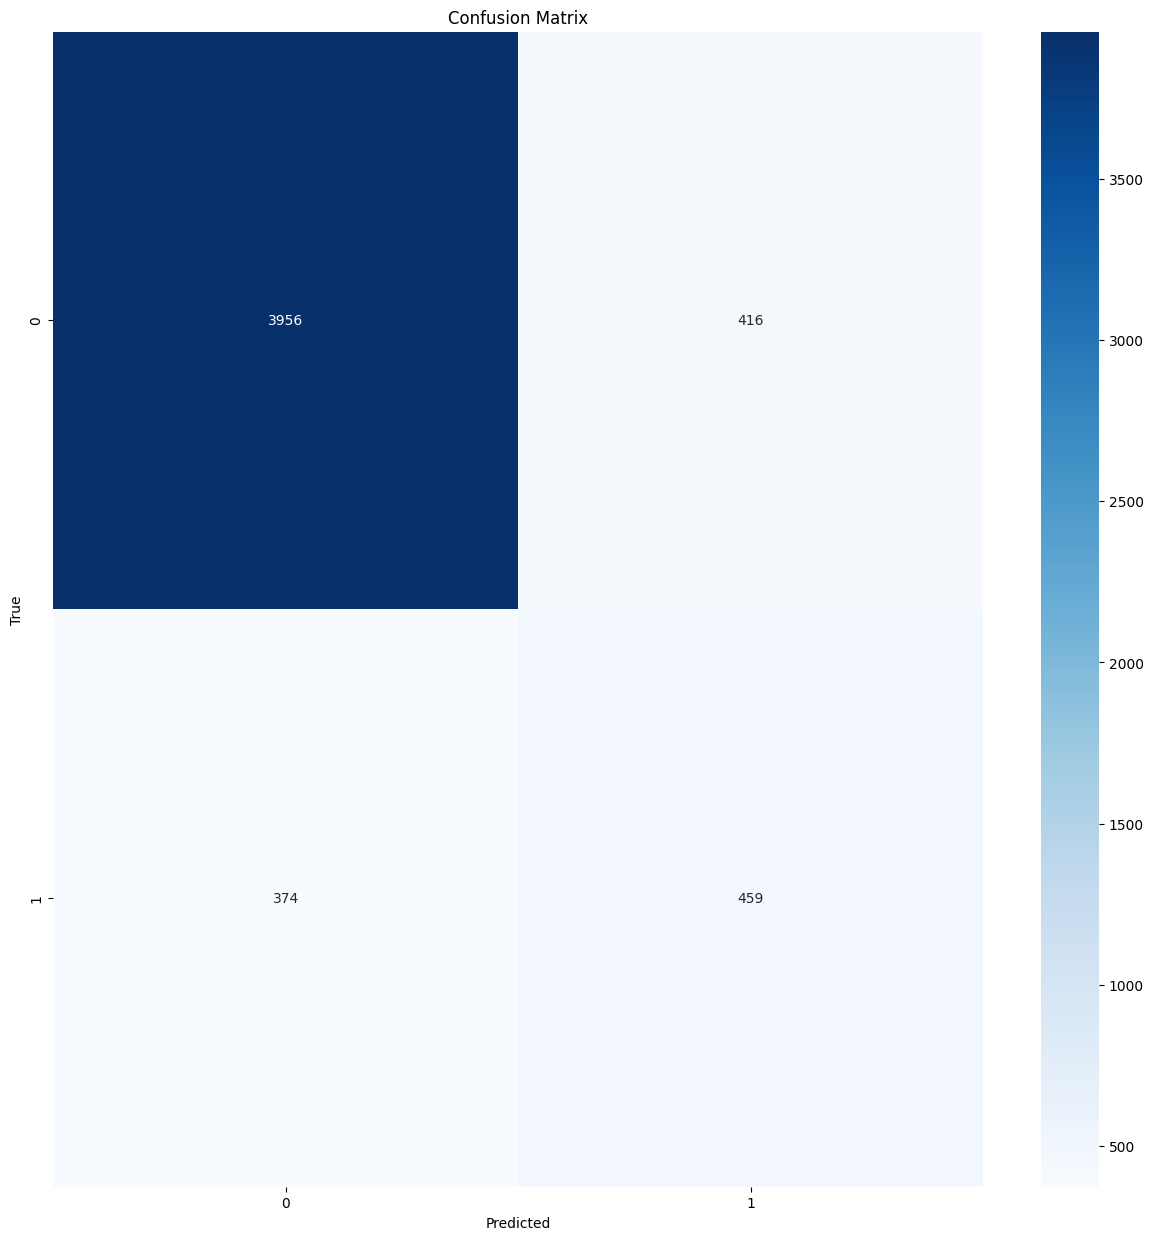

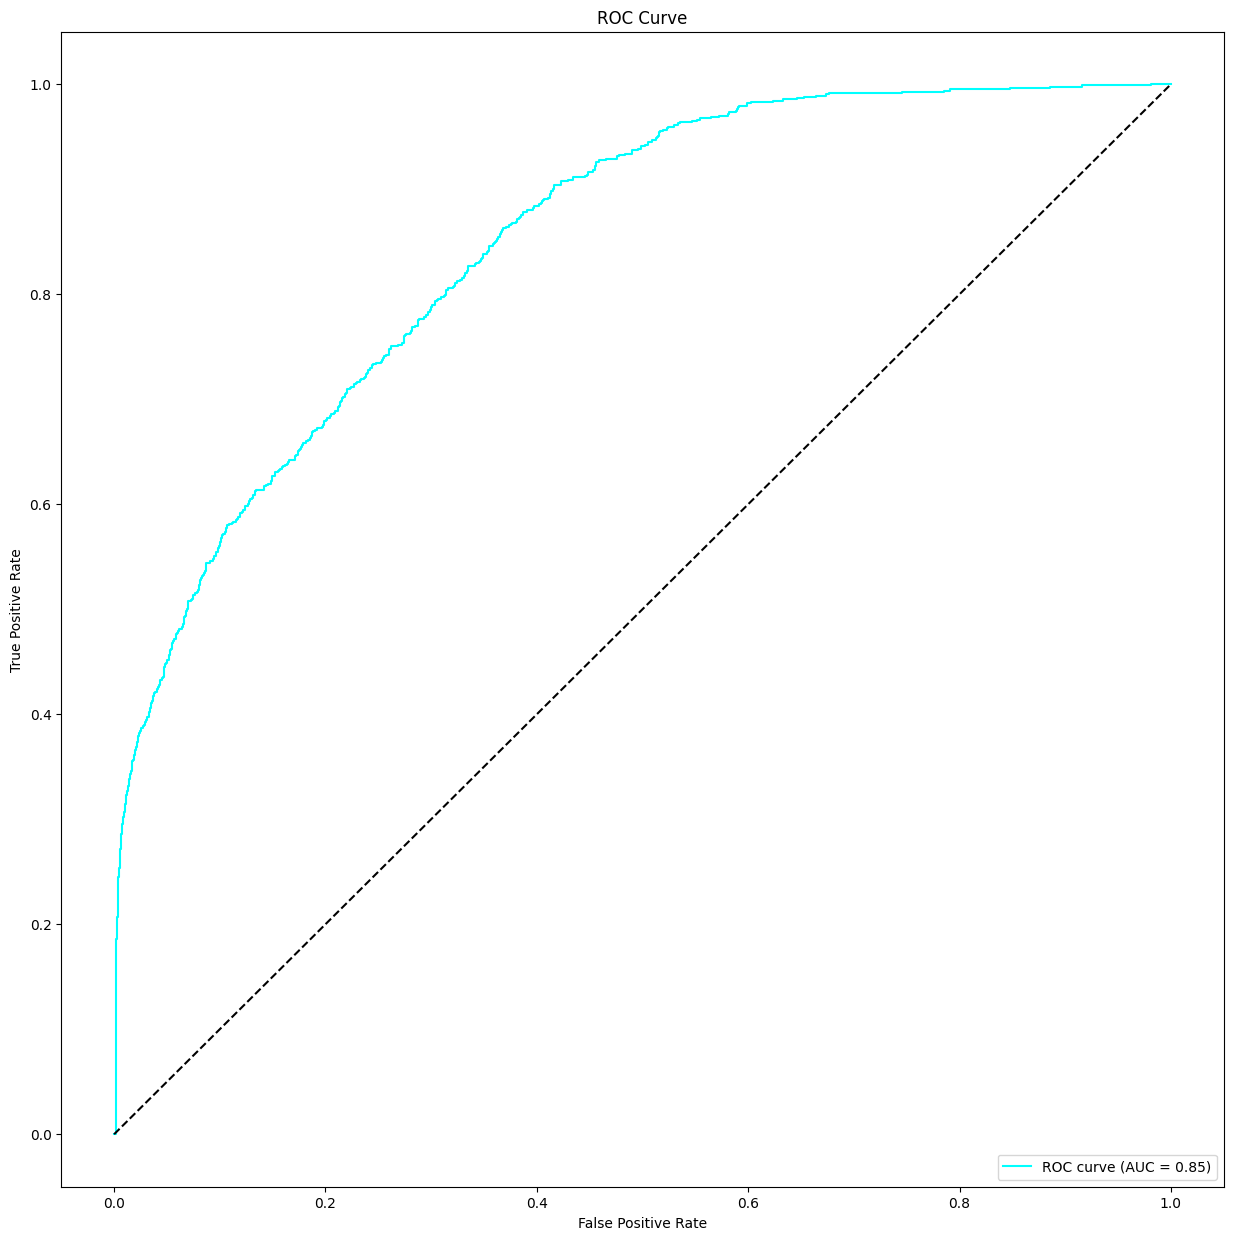

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      4372
           1       0.52      0.55      0.54       833

    accuracy                           0.85      5205
   macro avg       0.72      0.73      0.72      5205
weighted avg       0.85      0.85      0.85      5205

##################################################  Saliency Maps  ##################################################

Class 0:


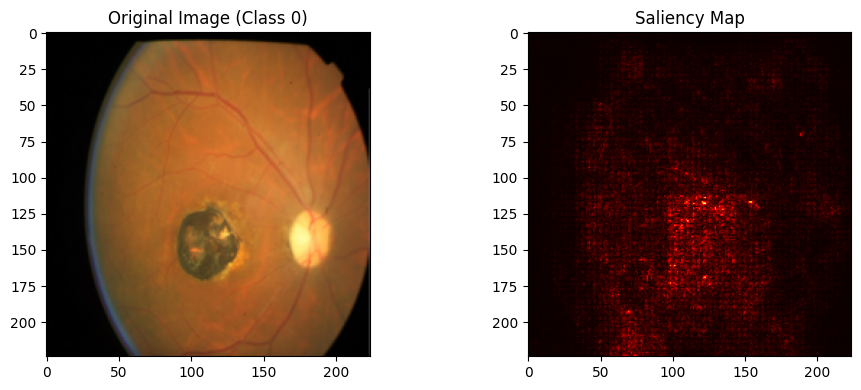

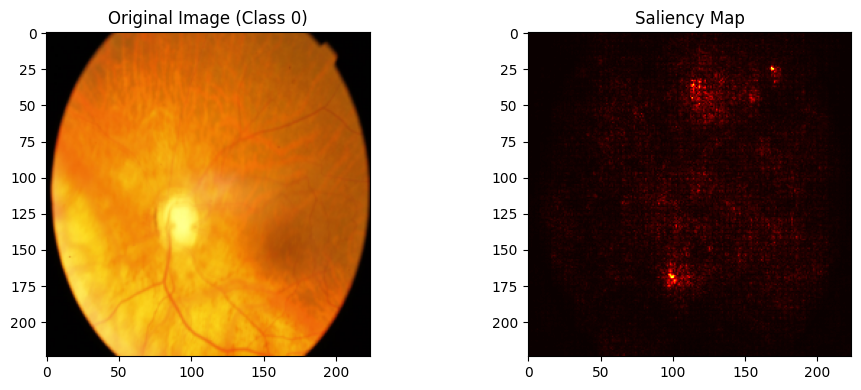

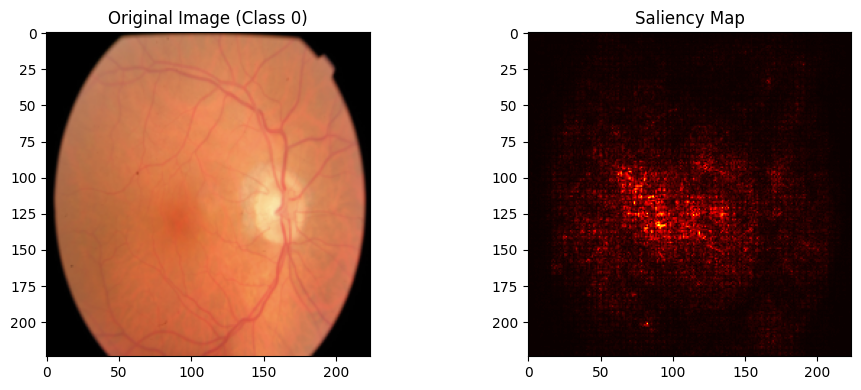

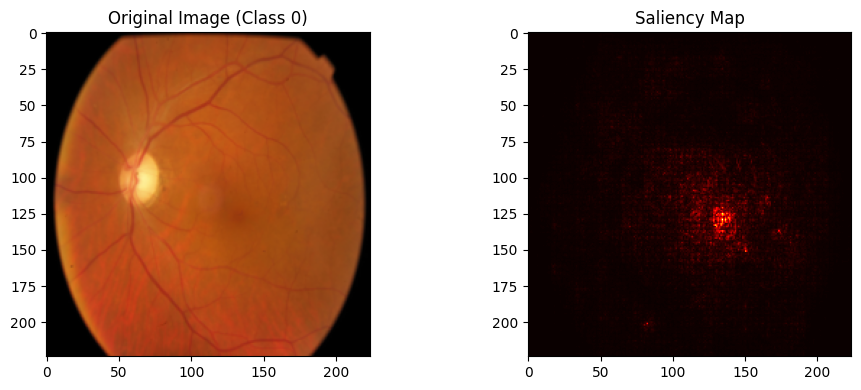

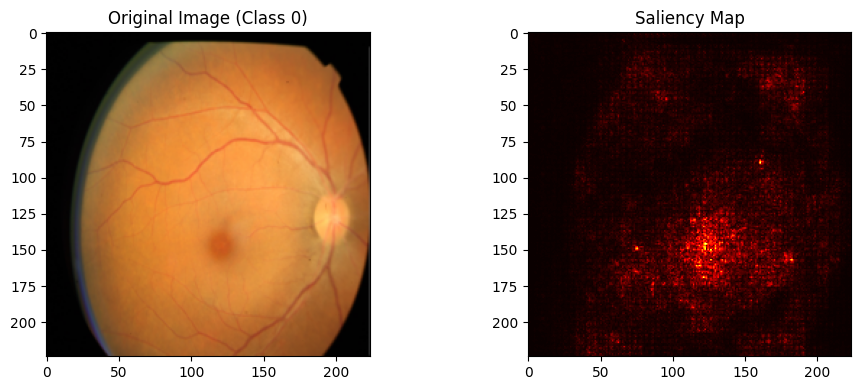

Class 1:


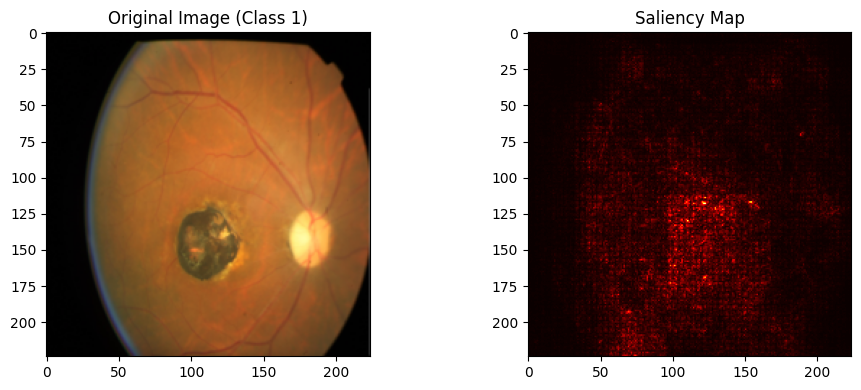

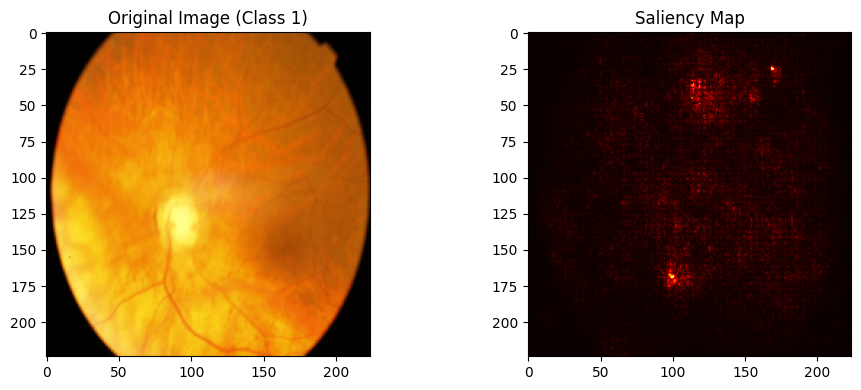

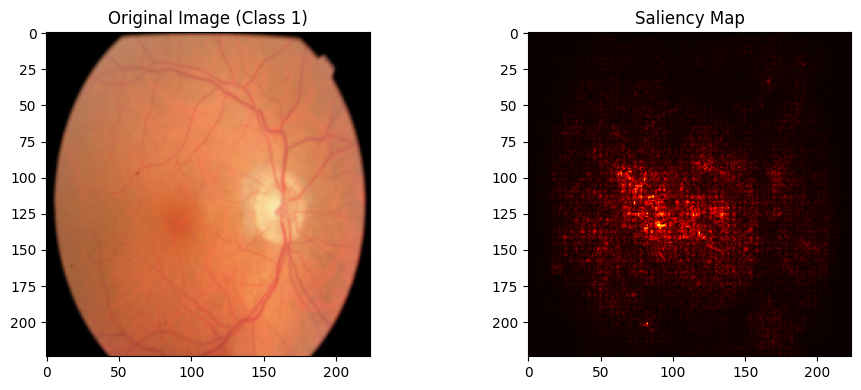

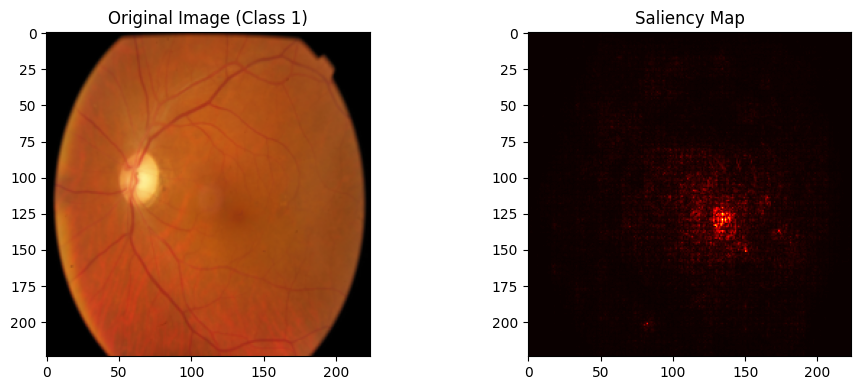

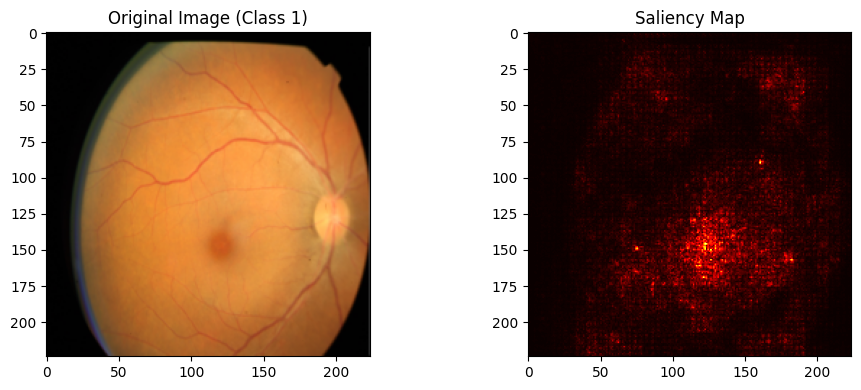

In [13]:
test(model, test_dataloader, saliency=True, device=device)

### Image quality assessment

In [14]:
# Good quality images
adequate_df = df_test[df_test['quality'] == 'Adequate']

# Bad quality images
inadequate_df = df_test[df_test['quality'] == 'Inadequate']

adequate_dataset = BRSETDataset(
    adequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

inadequate_dataset = BRSETDataset(
    inadequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

adequate_dataloader = DataLoader(adequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
inadequate_dataloader = DataLoader(inadequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

#### Adequate image quality

100%|██████████| 286/286 [00:41<00:00,  6.81it/s]


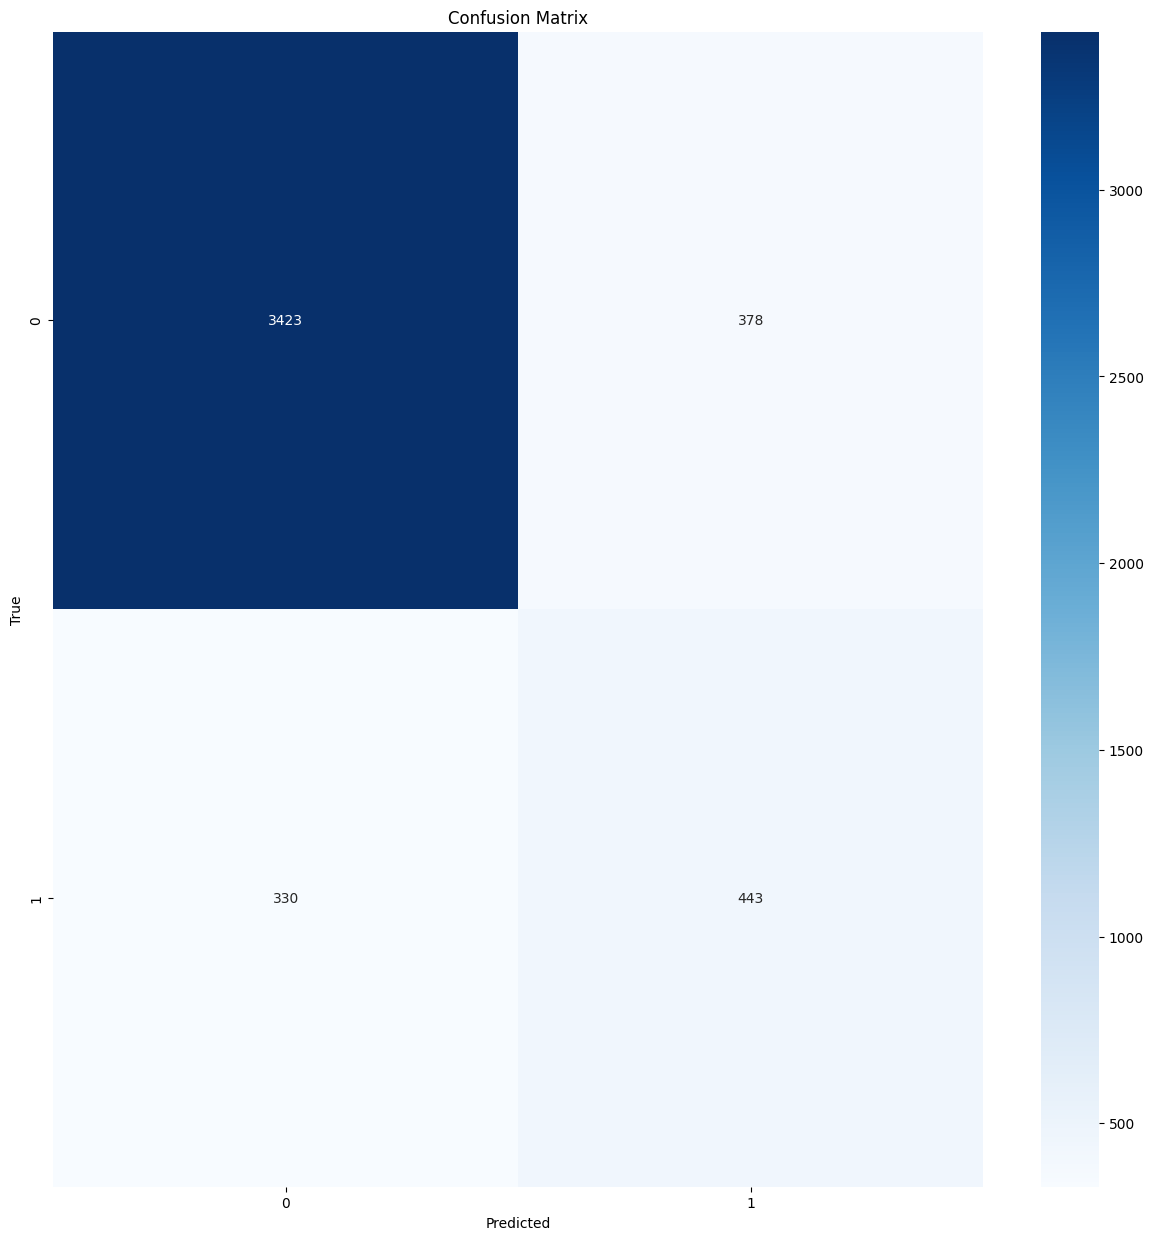

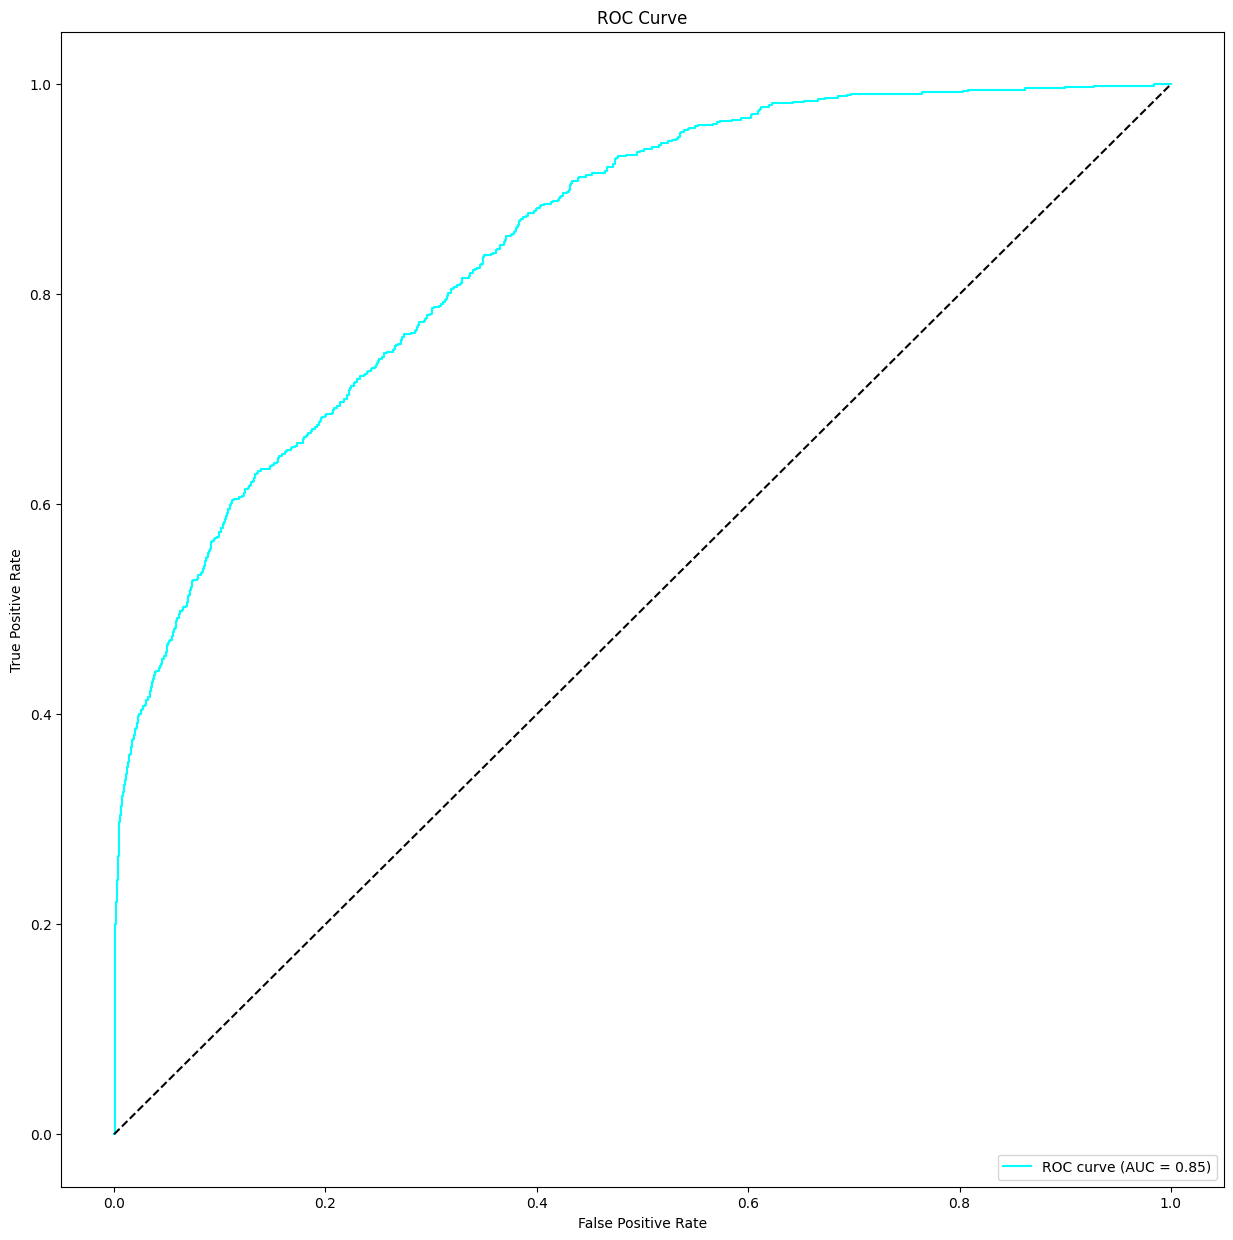

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      3801
           1       0.54      0.57      0.56       773

    accuracy                           0.85      4574
   macro avg       0.73      0.74      0.73      4574
weighted avg       0.85      0.85      0.85      4574

##################################################  Saliency Maps  ##################################################

Class 0:


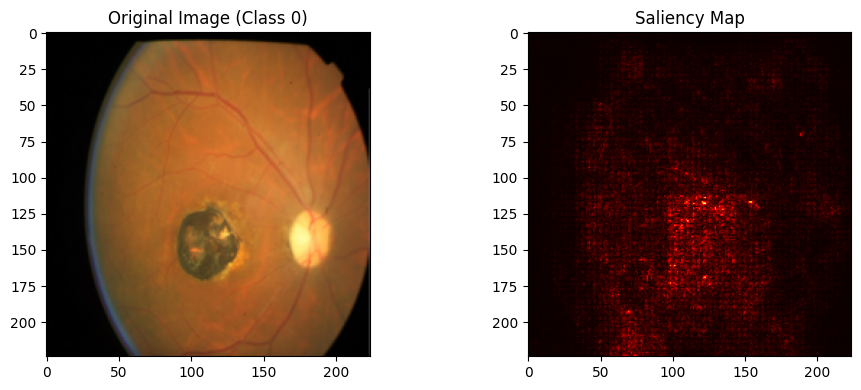

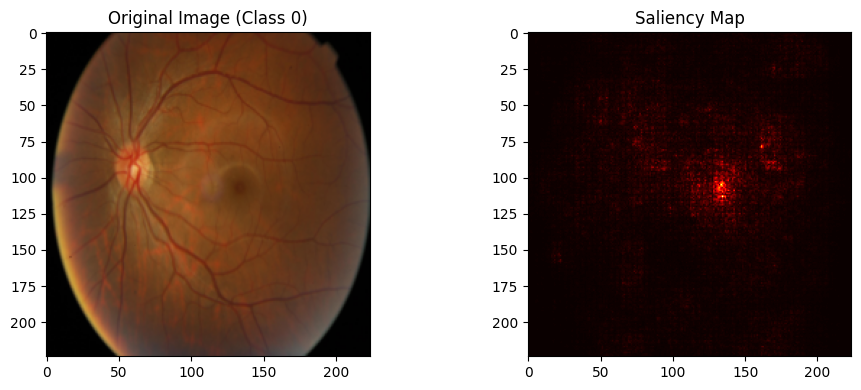

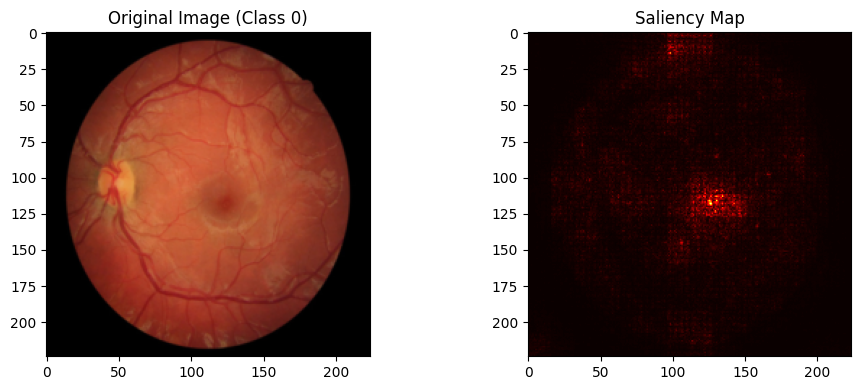

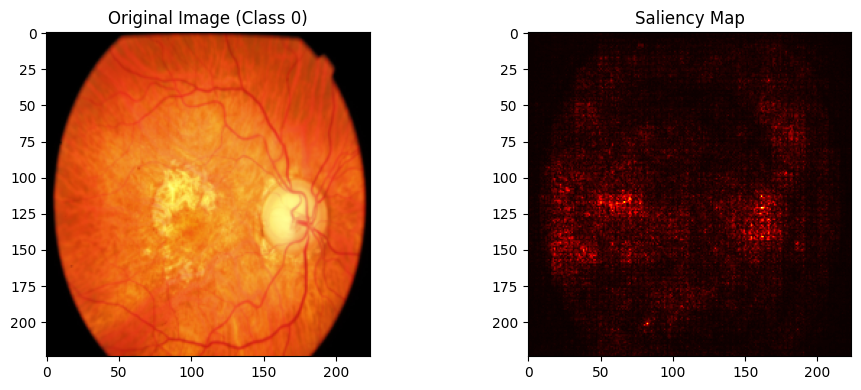

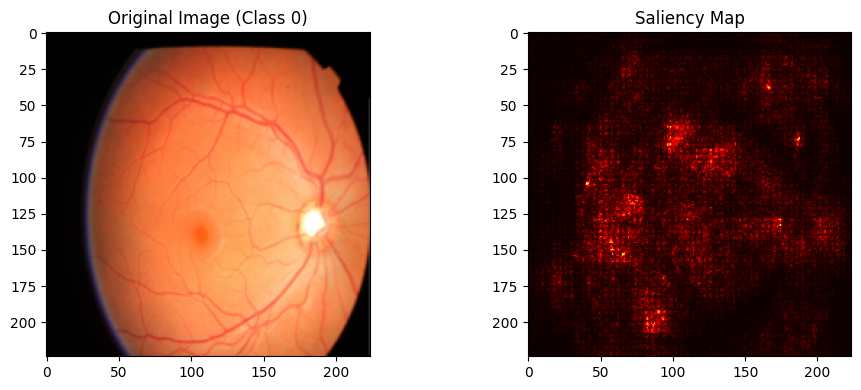

Class 1:


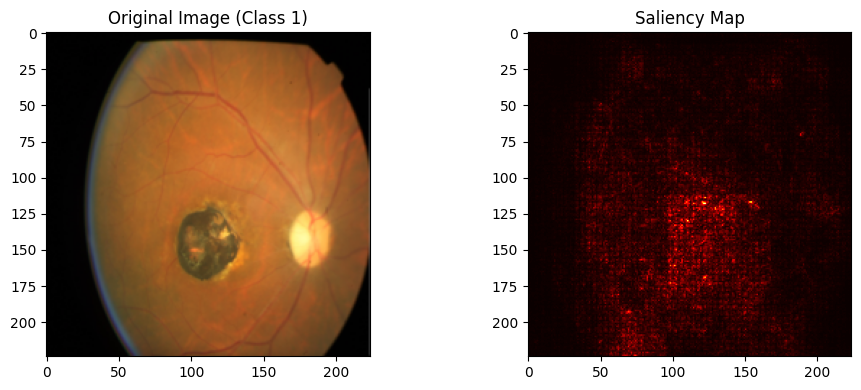

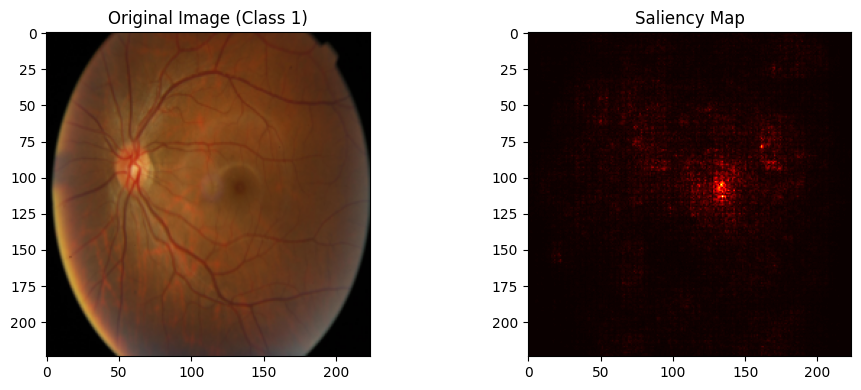

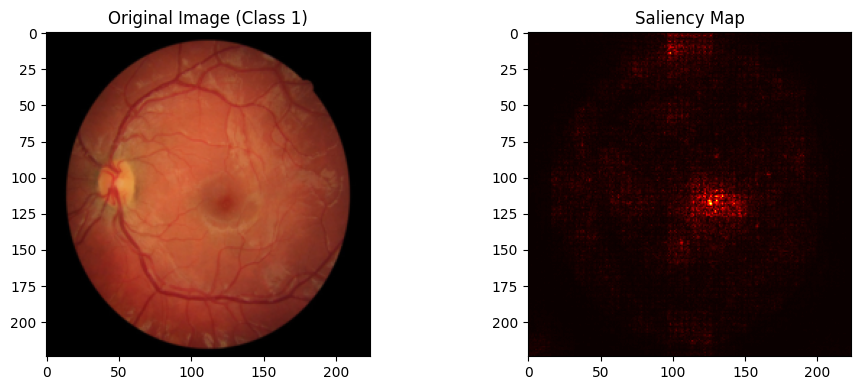

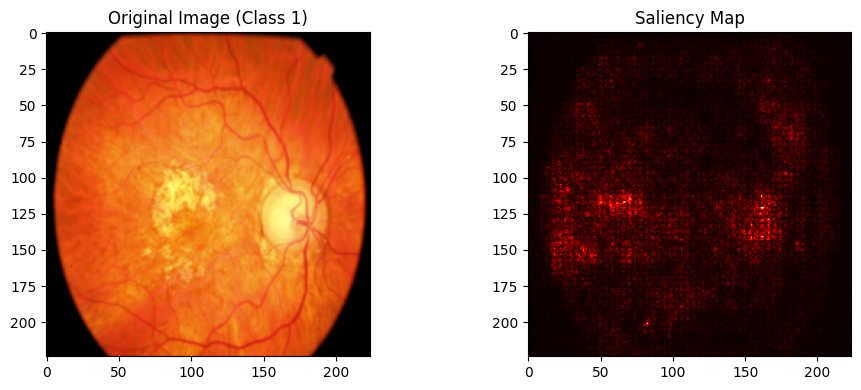

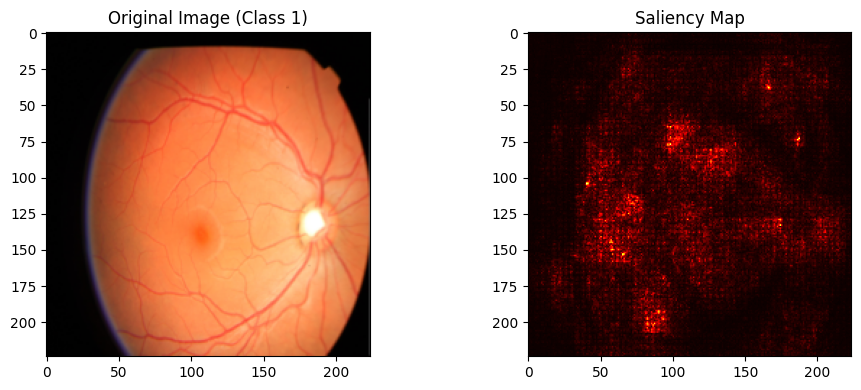

In [15]:
test(model, adequate_dataloader, saliency=True, device=device, save=True)

#### Inadequate image quality

100%|██████████| 40/40 [00:07<00:00,  5.49it/s]


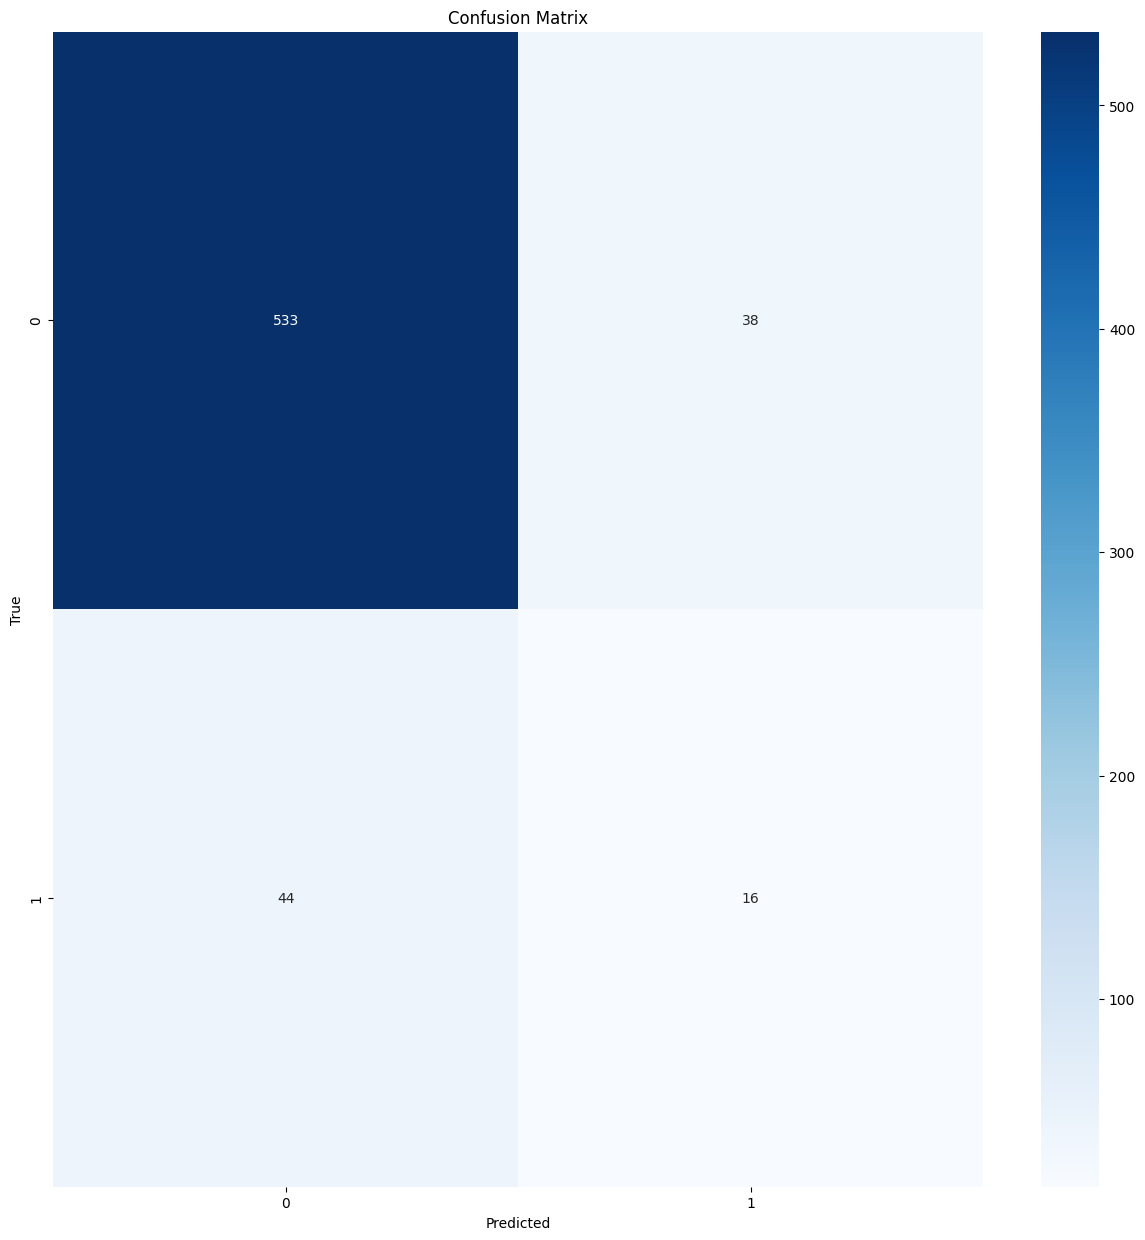

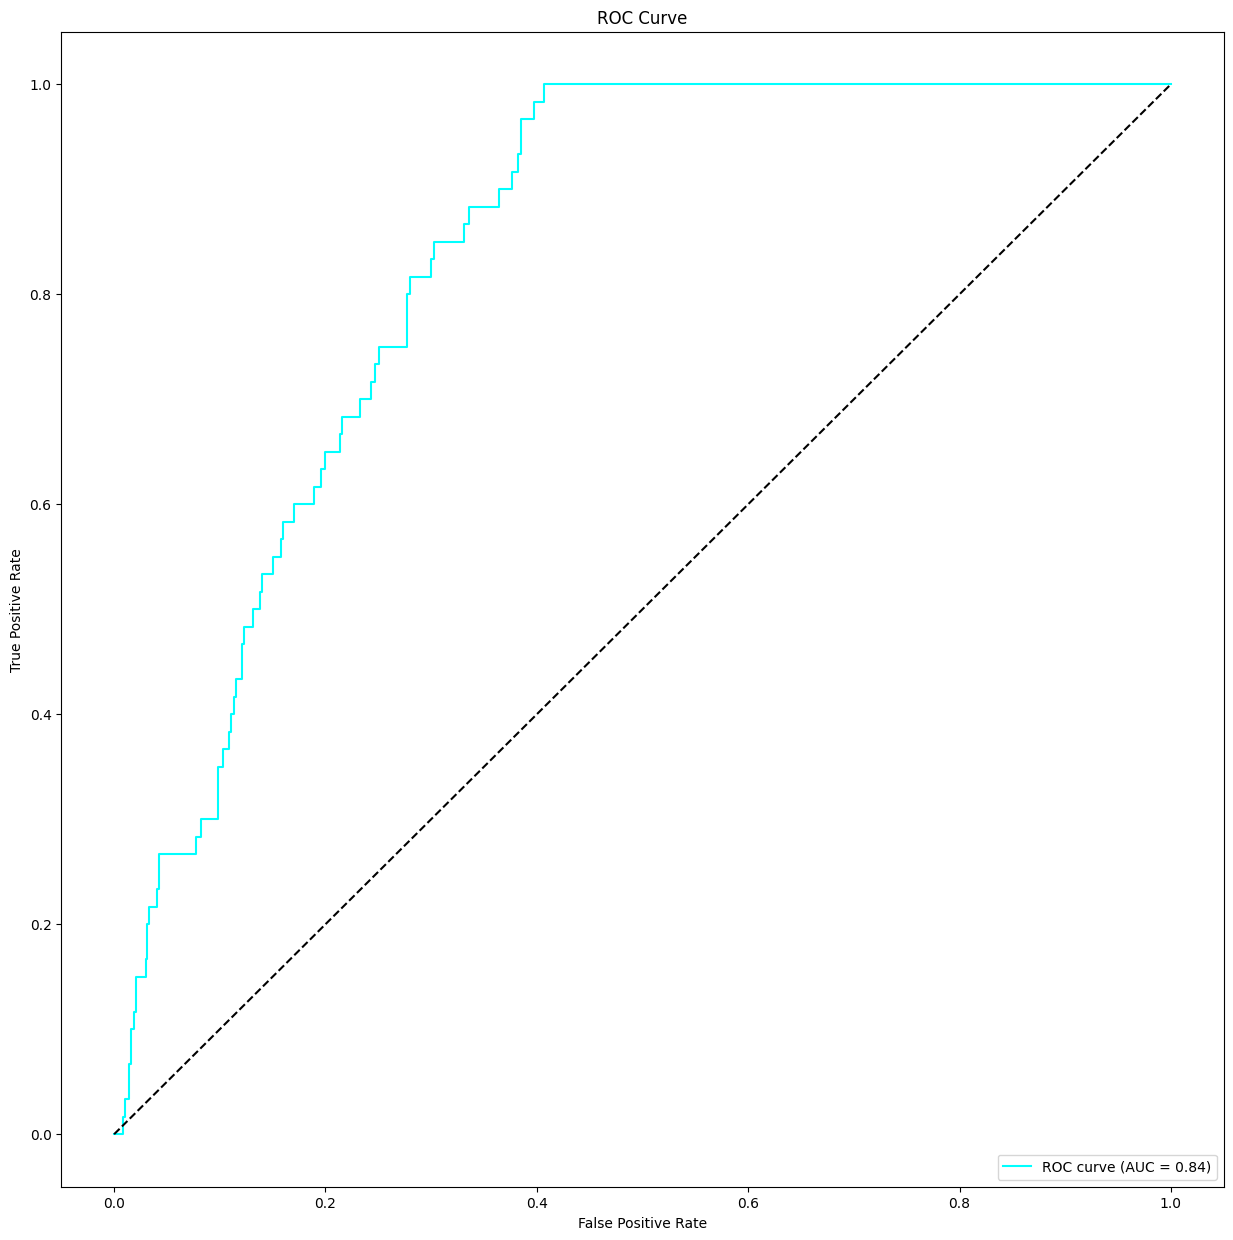

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       571
           1       0.30      0.27      0.28        60

    accuracy                           0.87       631
   macro avg       0.61      0.60      0.60       631
weighted avg       0.86      0.87      0.87       631

##################################################  Saliency Maps  ##################################################

Class 0:


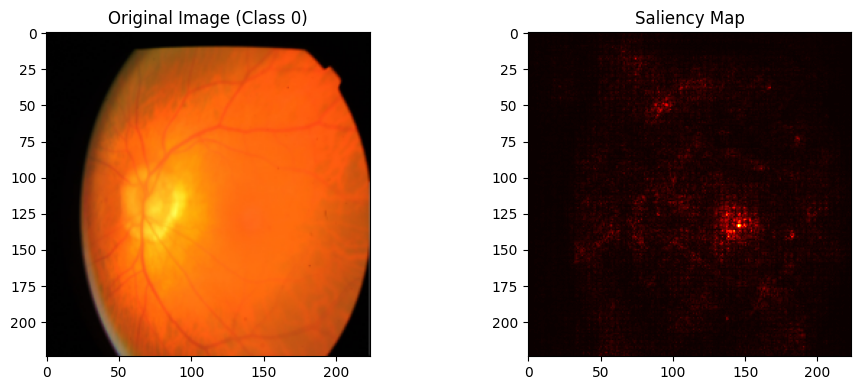

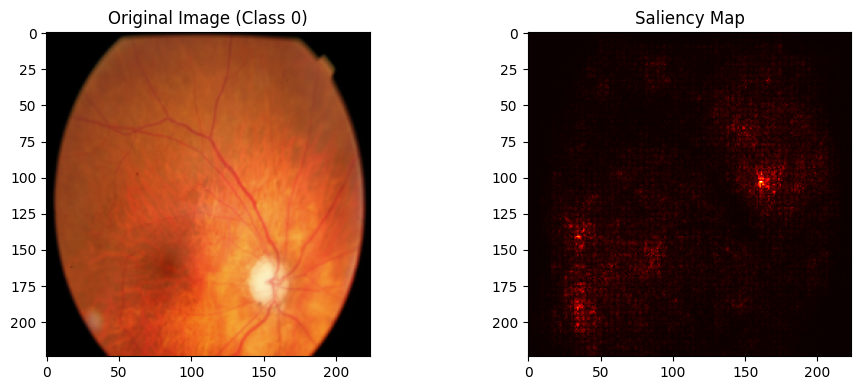

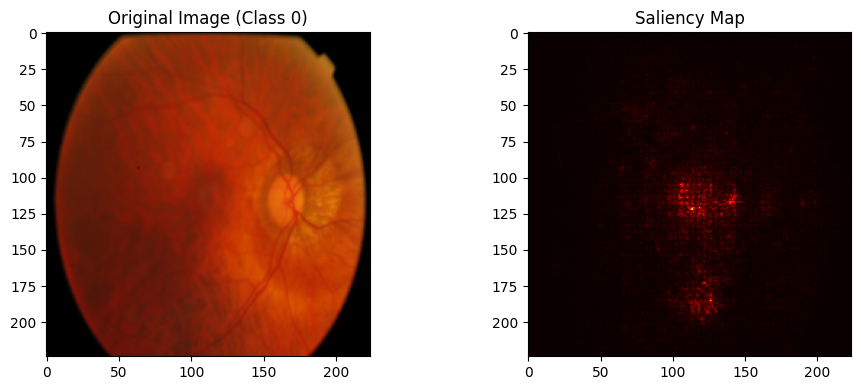

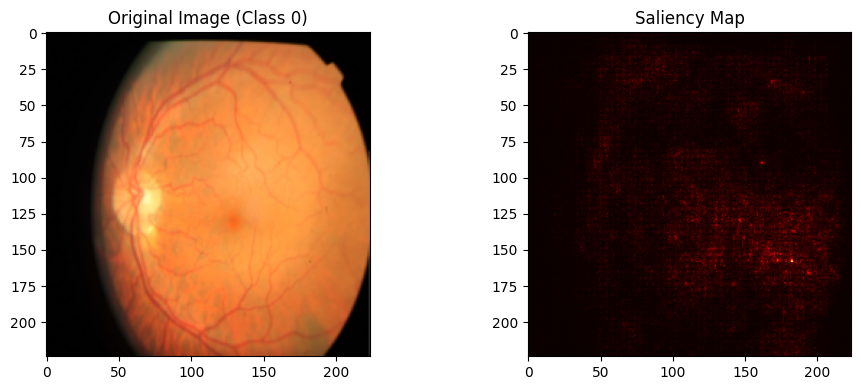

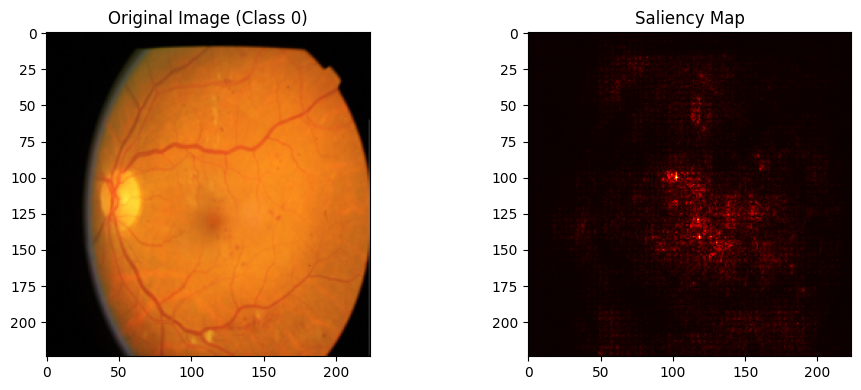

Class 1:


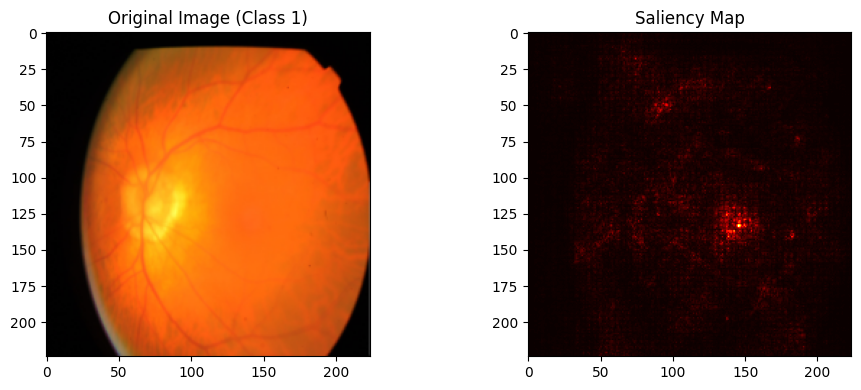

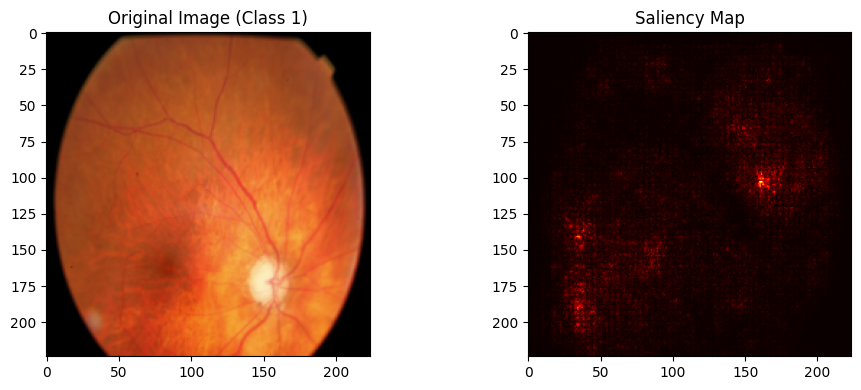

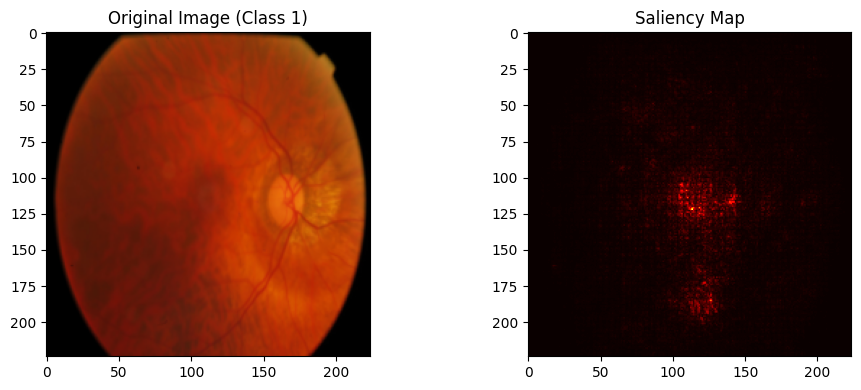

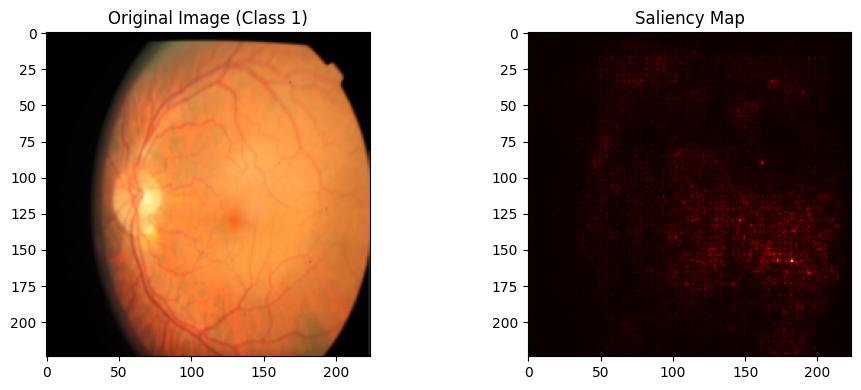

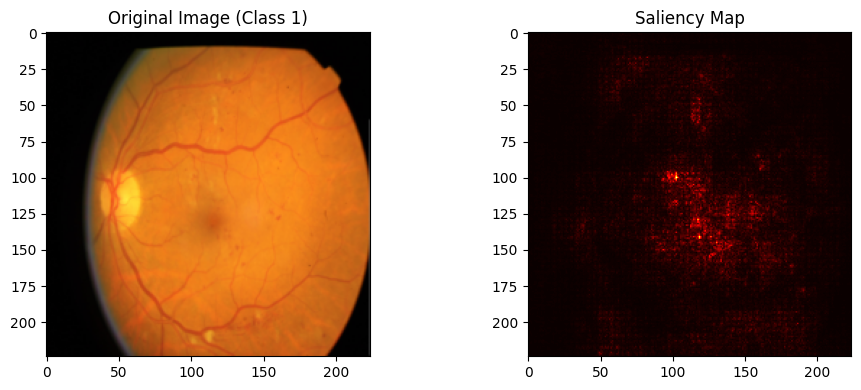

In [16]:
test(model, inadequate_dataloader, saliency=True, device=device)